# Movie Recommender System Using SVD

## Load Libraries and Dataset

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import requests

In [106]:
# Load MovieLens 25M dataset
ratings = pd.read_csv('../ml-25m/ratings.csv')
movies = pd.read_csv('../ml-25m/movies.csv')
links = pd.read_csv('../ml-25m/links.csv')
print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)

Ratings shape: (25000095, 4)
Movies shape: (62423, 3)


## API key to fetch the images from TMDB

In [107]:
TMDB_API_KEY = "2307c3e2979636e48540fc3c2c7dbaec"
TMDB_BASE_URL = "https://api.themoviedb.org/3/movie/{}/images?api_key={}"

In [108]:
movies_with_links = pd.merge(movies, links, on='movieId')

In [109]:
# Function to fetch poster path from tmdbId
def fetch_poster(tmdb_id):
    try:
        url = TMDB_BASE_URL.format(tmdb_id, TMDB_API_KEY)
        response = requests.get(url)
        data = response.json()
        posters = data.get('posters', [])
        if posters:
            return "https://image.tmdb.org/t/p/w200" + posters[0]['file_path']
    except Exception as e:
        print(f"Error fetching poster for {tmdb_id}: {e}")
    return None

## Exploratory Data Analysis

In [110]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [111]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


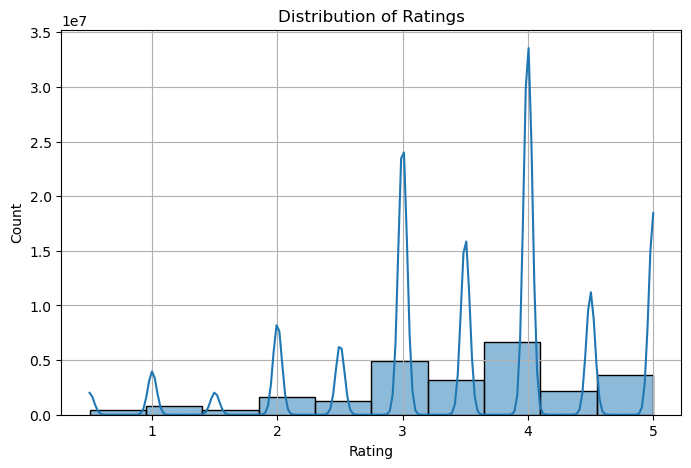

In [112]:
# Rating distribution
plt.figure(figsize=(8, 5))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(True)
plt.show()

## Data Preprocessing and Sparse Matrix

In [113]:
# Merge and encode
df = pd.merge(ratings, movies, on='movieId')
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
df['user_idx'] = user_encoder.fit_transform(df['userId'])
df['movie_idx'] = movie_encoder.fit_transform(df['title'])
ratings_sparse = csr_matrix((df['rating'], (df['user_idx'], df['movie_idx'])))
ratings_sparse.shape

(162541, 58958)

## Dimensionality Reduction with Truncated SVD

In [114]:
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(ratings_sparse)
movie_factors = svd.components_.T

In [115]:
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Total explained variance by {n_components} components: {explained_variance:.4f}")

Total explained variance by 50 components: 0.3599


## Movie Recommendation Function

In [119]:
def recommend_movies(user_id, user_encoder, movie_encoder, user_factors, movie_factors, movies_df, top_n=10):
    if user_id not in user_encoder.classes_:
        print(f"User {user_id} not found.")
        return []
    user_idx = user_encoder.transform([user_id])[0]
    predicted_ratings = np.dot(movie_factors, user_factors[user_idx])
    predicted_ratings = np.clip(predicted_ratings, 0.5, 5.0)
    movie_titles = movie_encoder.inverse_transform(np.arange(len(predicted_ratings)))
    recommendations = pd.DataFrame({
        'title': movie_titles,
        'predicted_rating': predicted_ratings
    })
    return recommendations.sort_values('predicted_rating', ascending=False).head(top_n)

In [143]:
from IPython.display import HTML

def display_with_posters(df):
    html = "<table><tr><th>Title</th><th>Predicted Rating</th><th>Poster</th></tr>"
    for _, row in df.iterrows():
        html += f"<tr><td>{row['title']}</td><td>{row['predicted_rating']:.2f}</td>"
        if row['poster_url']:
            html += f"<td><img src='{row['poster_url']}' width='300'></td></tr>"
        else:
            html += "<td>N/A</td></tr>"
    html += "</table>"
    return HTML(html)


## Top-N Recommendations for a Sample User

In [139]:
sample_user_id = ratings['userId'].sample(1).values[0]
#sample_user_id = 42780
print(f"Recommendations for User ID: {sample_user_id}")
recommendations = recommend_movies(sample_user_id, user_encoder, movie_encoder, user_factors, movie_factors, movies)
recommendations = pd.merge(recommendations, movies_with_links[['title', 'tmdbId']], on='title', how='left')
recommendations['poster_url'] = recommendations['tmdbId'].apply(fetch_poster)

Recommendations for User ID: 78473


In [140]:
movies_meta = movies[['movieId', 'title', 'genres']].drop_duplicates()

user_history = df[df['userId'] == sample_user_id].copy()
user_history = pd.merge(user_history, movies_meta, on='movieId', how='left')

# Debug what you have
#print("Columns after merge:", user_history.columns.tolist())

user_history = user_history[['title_y', 'rating', 'genres_y']].dropna().sort_values(by='rating', ascending=False)
user_history.columns = ['title', 'rating', 'genres']  # Rename for clean display

print(f"\nUser {sample_user_id} has rated {len(user_history)} movies:")
user_history.head(10)


User 78473 has rated 614 movies:


,title,rating,genres
188,My Life as a Dog (Mitt liv som hund) (1985),5.0,Comedy|Drama
447,Don't Look Now (1973),5.0,Drama|Horror|Thriller
350,"Last Picture Show, The (1971)",5.0,Drama
148,One Flew Over the Cuckoo's Nest (1975),5.0,Drama
102,Fargo (1996),5.0,Comedy|Crime|Drama|Thriller
321,"400 Blows, The (Les quatre cents coups) (1959)",5.0,Crime|Drama
305,Office Space (1999),4.5,Comedy|Crime
281,"Player, The (1992)",4.5,Comedy|Crime|Drama
12,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),4.5,Mystery|Sci-Fi|Thriller
598,"Pan's Labyrinth (Laberinto del fauno, El) (2006)",4.5,Drama|Fantasy|Thriller


In [144]:
display_with_posters(recommendations)

Title,Predicted Rating,Poster
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),5.00,
Eternal Sunshine of the Spotless Mind (2004),5.00,
Taxi Driver (1976),5.00,
"Clockwork Orange, A (1971)",5.00,
Apocalypse Now (1979),4.92,
Blade Runner (1982),4.81,
Seven (a.k.a. Se7en) (1995),4.77,
"Shining, The (1980)",4.73,
Being John Malkovich (1999),4.70,
Pulp Fiction (1994),4.68,


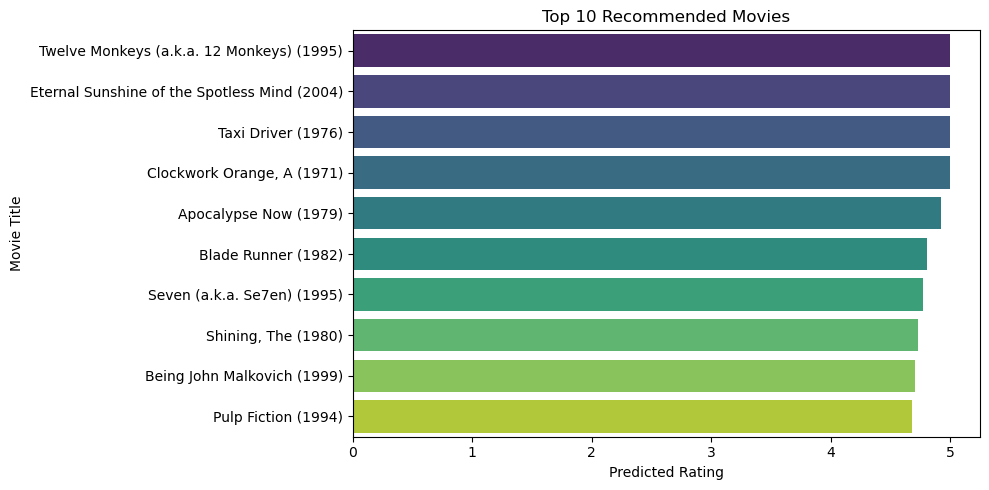

In [142]:
plt.figure(figsize=(10, 5))
sns.barplot(data=recommendations, x='predicted_rating', y='title', hue='title', dodge=False, palette='viridis', legend=False)
plt.title(f'Top {len(recommendations)} Recommended Movies')
plt.xlabel('Predicted Rating')
plt.ylabel('Movie Title')
plt.tight_layout()
plt.show()

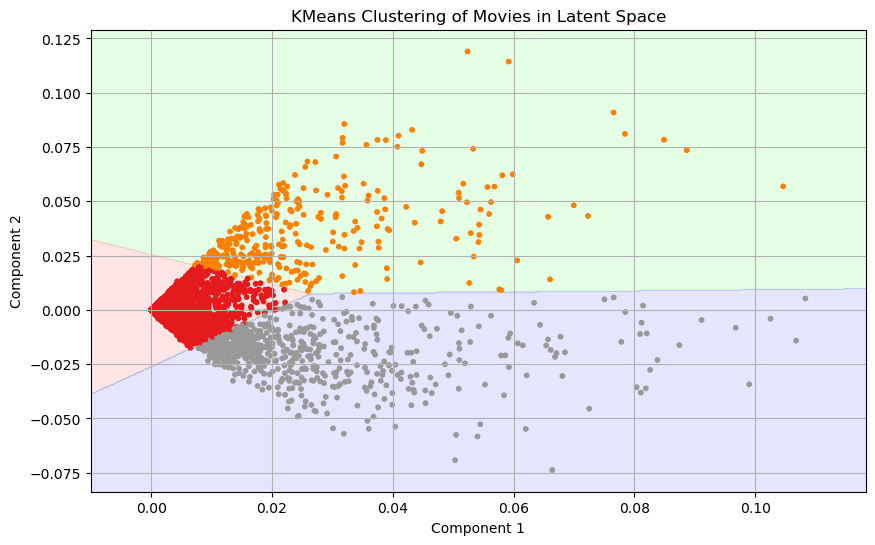

In [36]:
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

# Use first 2 SVD components for clustering
X = movie_factors[:, :2]

# Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)

# Create background grid
x_min, x_max = X[:, 0].min() - .01, X[:, 0].max() + .01
y_min, y_max = X[:, 1].min() - .01, X[:, 1].max() + .01
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision regions and movie points
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']), alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='Set1', s=10)
plt.title("KMeans Clustering of Movies in Latent Space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

## Train-Test Split and Evaluation

In [14]:
sample_users = df['userId'].value_counts().head(500).index
sample_df = df[df['userId'].isin(sample_users)].copy()
sample_df['user_idx'] = user_encoder.fit_transform(sample_df['userId'])
sample_df['movie_idx'] = movie_encoder.fit_transform(sample_df['title'])
train_df, test_df = train_test_split(sample_df, test_size=0.2, random_state=42)
train_matrix = csr_matrix((train_df['rating'], (train_df['user_idx'], train_df['movie_idx'])),
                          shape=(sample_df['user_idx'].nunique(), sample_df['movie_idx'].nunique()))
svd_eval = TruncatedSVD(n_components=30, random_state=42)
user_factors_eval = svd_eval.fit_transform(train_matrix)
movie_factors_eval = svd_eval.components_.T

In [16]:
predictions, actuals = [], []
for _, row in test_df.iterrows():
    u, m = row['user_idx'], row['movie_idx']
    if u < user_factors_eval.shape[0] and m < movie_factors_eval.shape[0]:
        predictions.append(np.dot(user_factors_eval[u], movie_factors_eval[m]))
        actuals.append(row['rating'])
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 2.1990
MAE: 1.9241
